In [13]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import holidays
import warnings
warnings.filterwarnings('ignore')

# Thư viện Machine Learning
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb

# Thư viện Statistical Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Đọc dữ liệu
df = pd.read_csv('/kaggle/input/atm-cash-demand-forecasting-and-management/atm_cash_management_dataset.csv')

In [15]:
# 1. PHÂN TÍCH DỮ LIỆU (EDA)
print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (5658, 15)

Dataset columns: ['ATM_ID', 'Date', 'Day_of_Week', 'Time_of_Day', 'Total_Withdrawals', 'Total_Deposits', 'Location_Type', 'Holiday_Flag', 'Special_Event_Flag', 'Previous_Day_Cash_Level', 'Weather_Condition', 'Nearby_Competitor_ATMs', 'Cash_Demand_Next_Day', 'day_of_week', 'is_weekend']

First 5 rows:
     ATM_ID       Date Day_of_Week Time_of_Day  Total_Withdrawals  \
0  ATM_0041 2022-04-25      Monday     Morning              57450   
1  ATM_0007 2023-11-24      Friday     Morning              72845   
2  ATM_0014 2022-08-27    Saturday     Morning              42957   
3  ATM_0029 2023-08-27      Sunday     Evening              43014   
4  ATM_0028 2022-12-15    Thursday     Evening              36379   

   Total_Deposits Location_Type  Holiday_Flag  Special_Event_Flag  \
0            9308    Standalone             0                   0   
1           17896   Supermarket             0                   0   
2           12712   Supermarket             0    

In [16]:
# Kiểm tra giá trị missing
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
ATM_ID                     0
Date                       0
Day_of_Week                0
Time_of_Day                0
Total_Withdrawals          0
Total_Deposits             0
Location_Type              0
Holiday_Flag               0
Special_Event_Flag         0
Previous_Day_Cash_Level    0
Weather_Condition          0
Nearby_Competitor_ATMs     0
Cash_Demand_Next_Day       0
day_of_week                0
is_weekend                 0
dtype: int64



Date range: from 2022-01-01 00:00:00 to 2024-01-01 00:00:00

Number of unique ATMs: 50


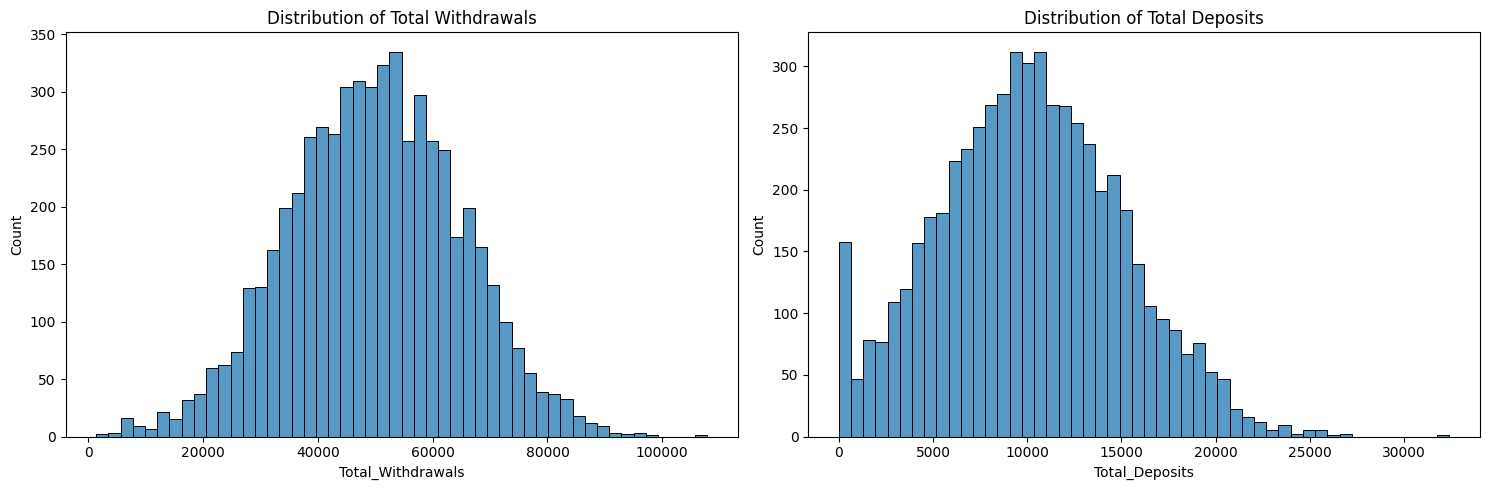

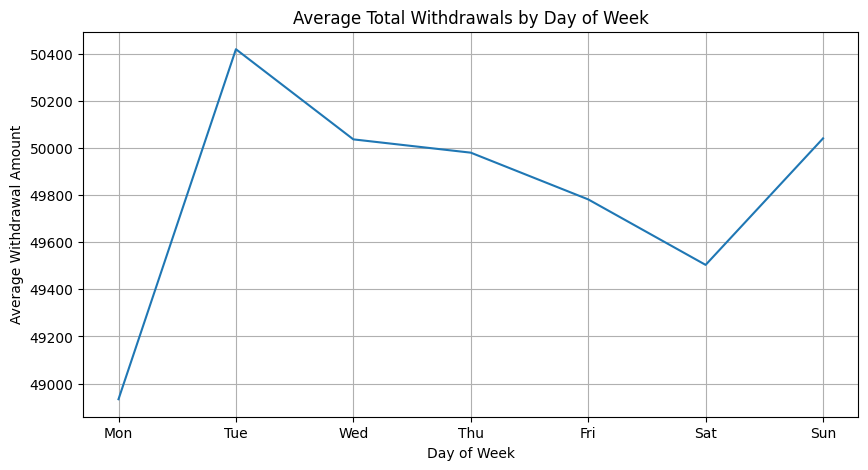

In [17]:
# Chuyển cột Date sang kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])
print("\nDate range: from", df['Date'].min(), "to", df['Date'].max())

# Số lượng ATM duy nhất
print("\nNumber of unique ATMs:", df['ATM_ID'].nunique())

# Phân phối của Total_Withdrawals và Total_Deposits
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['Total_Withdrawals'], bins=50, ax=axes[0])
axes[0].set_title('Distribution of Total Withdrawals')
sns.histplot(df['Total_Deposits'], bins=50, ax=axes[1])
axes[1].set_title('Distribution of Total Deposits')
plt.tight_layout()
plt.show()

# Phân tích tính thời vụ (theo ngày trong tuần)
df['day_of_week'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
weekly_pattern = df.groupby('day_of_week')['Total_Withdrawals'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10, 5))
plt.plot(days, weekly_pattern)
plt.title('Average Total Withdrawals by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Withdrawal Amount')
plt.grid(True)
plt.show()

In [18]:
# 2. TIỀN XỬ LÝ DỮ LIỆU VÀ FEATURE ENGINEERING
# Tạo các đặc trưu thời gian
df['month'] = df['Date'].dt.month
df['day_of_month'] = df['Date'].dt.day
df['year'] = df['Date'].dt.year
df['quarter'] = df['Date'].dt.quarter

# Tạo đặc trưu ngày lễ (ví dụ cho US holidays)
us_holidays = holidays.US(years=range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1))
df['is_holiday'] = df['Date'].isin(us_holidays).astype(int)

# Sắp xếp dữ liệu theo ATM và ngày
df = df.sort_values(['ATM_ID', 'Date']).reset_index(drop=True)

# Tạo lag features cho từng ATM
lags = [1, 2, 3, 7, 14, 30]  # các lag 1, 2, 3, 7, 14, 30 ngày

for lag in lags:
    df[f'withdrawal_lag_{lag}'] = df.groupby('ATM_ID')['Total_Withdrawals'].shift(lag)
    df[f'deposit_lag_{lag}'] = df.groupby('ATM_ID')['Total_Deposits'].shift(lag)

# Tạo rolling features
df['rolling_mean_7'] = df.groupby('ATM_ID')['Total_Withdrawals'].transform(lambda x: x.rolling(7).mean())
df['rolling_std_7'] = df.groupby('ATM_ID')['Total_Withdrawals'].transform(lambda x: x.rolling(7).std())
df['rolling_mean_30'] = df.groupby('ATM_ID')['Total_Withdrawals'].transform(lambda x: x.rolling(30).mean())

# Xử lý missing values từ lag và rolling features
df = df.dropna()

In [19]:
# 3. CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH
# Xác định features và target
categorical_features = ['Weather_Condition', 'Location_Type']
numerical_features = ['day_of_week', 'is_weekend', 'month', 'day_of_month', 
                     'year', 'quarter', 'is_holiday', 'Previous_Day_Cash_Level', 'Holiday_Flag',
                     'Special_Event_Flag', 'Nearby_Competitor_ATMs'] + \
                    [f'withdrawal_lag_{lag}' for lag in lags] + \
                    [f'deposit_lag_{lag}' for lag in lags] + \
                    ['rolling_mean_7', 'rolling_std_7', 'rolling_mean_30']

target = 'Cash_Demand_Next_Day'

In [20]:
# Chia tập train/test theo thời gian (lấy 80% đầu làm train, 20% cuối làm test)
df = df.sort_values('Date')
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = train_df[numerical_features + categorical_features]
y_train = train_df[target]
X_test = test_df[numerical_features + categorical_features]
y_test = test_df[target]

# Tạo preprocessor để xử lý categorical và numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Áp dụng preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [21]:
# 4. XÂY DỰNG VÀ ĐÁNH GIÁ MÔ HÌNH
# LightGBM model
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [23]:
# Train với early stopping
from lightgbm import early_stopping, log_evaluation

# Train với early stopping (phiên bản mới LightGBM >= 4.0)
lgb_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_test_processed, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)


# Dự báo và đánh giá
lgb_preds = lgb_model.predict(X_test_processed, num_iteration=lgb_model.best_iteration_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4178
[LightGBM] [Info] Number of data points in the train set: 3326, number of used features: 35
[LightGBM] [Info] Start training from score 43344.297956
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 15054.7	valid_0's l2: 2.26645e+08
[100]	valid_0's rmse: 14941.2	valid_0's l2: 2.2324e+08
Early stopping, best iteration is:
[85]	valid_0's rmse: 14907.2	valid_0's l2: 2.22225e+08


In [24]:
print("LightGBM Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lgb_preds)))
print("MAE:", mean_absolute_error(y_test, lgb_preds))
print("MAPE:", mean_absolute_percentage_error(y_test, lgb_preds))

LightGBM Results:
RMSE: 14907.214438943178
MAE: 12055.293032240492
MAPE: 3.8788469935651366e+17


In [25]:
# 5. CHIẾN LƯỢC TIẾP QUỸ ATM
# Tính toán sai số để xác định buffer
errors = y_test - lgb_preds
std_error = np.std(errors)

# Đề xuất lượng tiền cần nạp với buffer 1.5*std_error (≈ 90% confidence interval)
test_df = test_df.copy()
test_df['predicted_demand'] = lgb_preds
test_df['required_buffer'] = 1.5 * std_error
test_df['suggested_load'] = test_df['predicted_demand'] + test_df['required_buffer'] - test_df['Previous_Day_Cash_Level']

# Đảm bảo lượng nạp không âm
test_df['suggested_load'] = test_df['suggested_load'].apply(lambda x: max(0, x))

# Hiển thị kết quả đề xuất cho một vài ATM
print("\nCash Replenishment Suggestions:")
print(test_df[['ATM_ID', 'Date', 'Cash_Demand_Next_Day', 'Previous_Day_Cash_Level', 
               'predicted_demand', 'required_buffer', 'suggested_load']].head(10))


Cash Replenishment Suggestions:
        ATM_ID       Date  Cash_Demand_Next_Day  Previous_Day_Cash_Level  \
5080  ATM_0045 2023-09-20                 31646                   136410   
4707  ATM_0042 2023-09-20                 46455                    82676   
2710  ATM_0024 2023-09-20                 35741                   108566   
4708  ATM_0042 2023-09-21                 65020                   134947   
3707  ATM_0033 2023-09-21                 53411                    97736   
647   ATM_0006 2023-09-21                 50154                    94377   
4028  ATM_0036 2023-09-21                 44573                    78582   
4825  ATM_0043 2023-09-21                 38264                   118780   
648   ATM_0006 2023-09-22                 51606                    86323   
1589  ATM_0014 2023-09-22                 37938                   101380   

      predicted_demand  required_buffer  suggested_load  
5080      37122.557770     22357.855737             0.0  
4707      3927

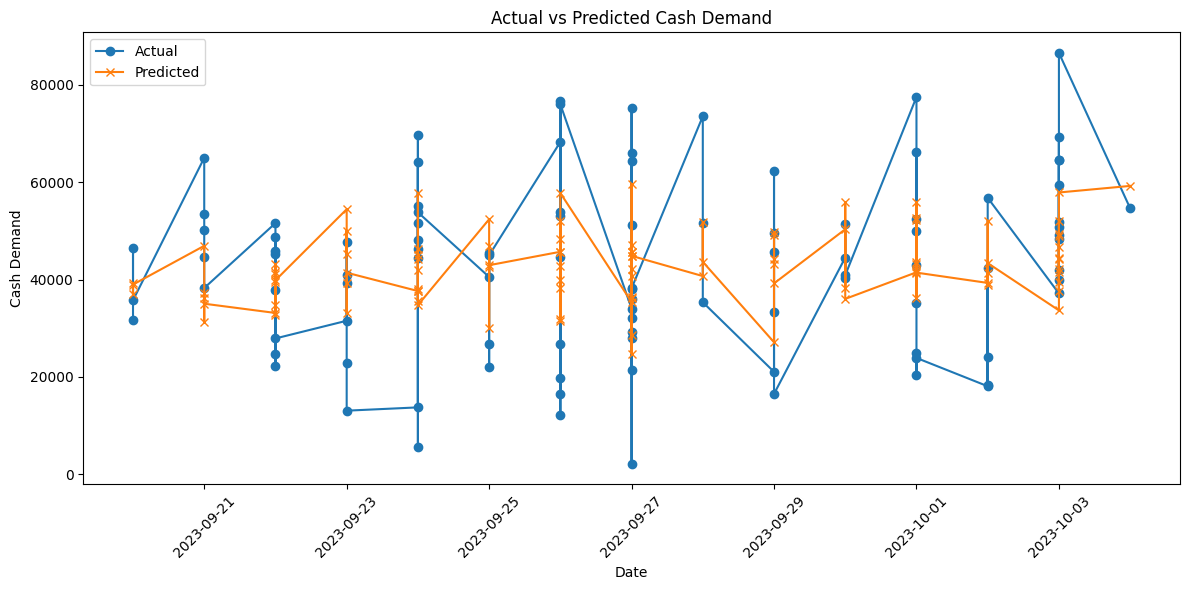

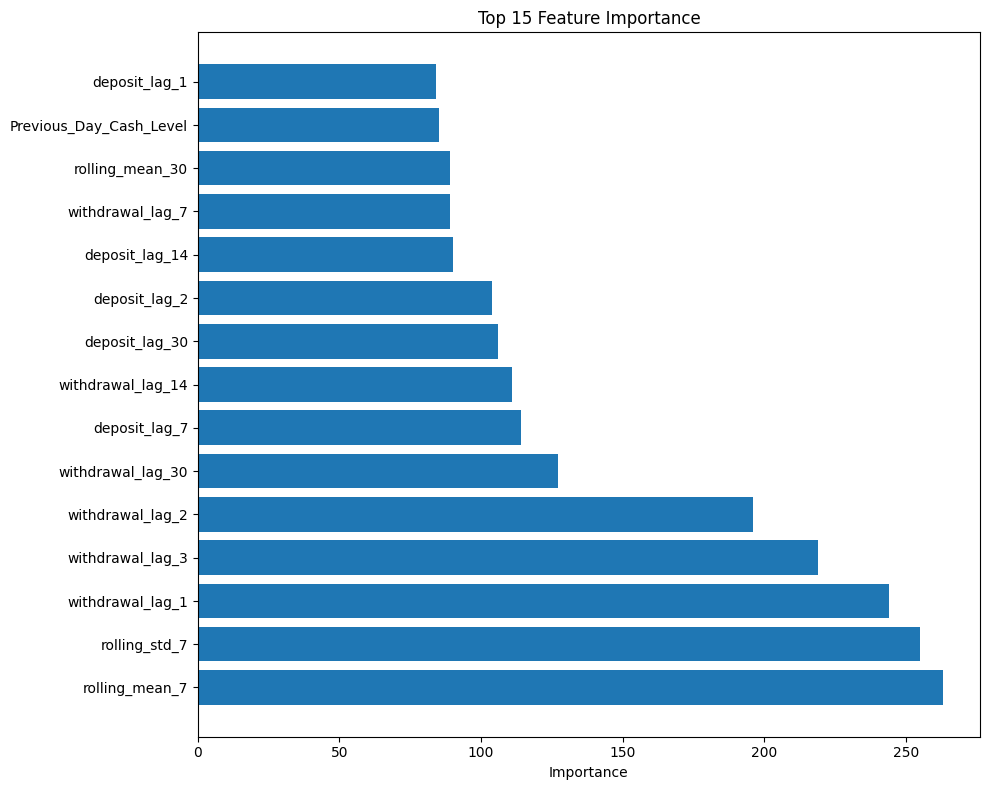

In [26]:
# 6. TRỰC QUAN HÓA KẾT QUẢ
# So sánh dự báo và thực tế
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'].values[:100], y_test.values[:100], label='Actual', marker='o')
plt.plot(test_df['Date'].values[:100], lgb_preds[:100], label='Predicted', marker='x')
plt.title('Actual vs Predicted Cash Demand')
plt.xlabel('Date')
plt.ylabel('Cash Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': lgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 15 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()